In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from collections import Counter, defaultdict

import torch
from transformers import AutoTokenizer, AutoModel

from src.utils import *
from src.config import Config

CONFIG:Config = Config()

/Users/matteoperiani/miniconda3/envs/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [86]:
df = pd.read_pickle(CONFIG.dataset.train_data_preproc)
df.head()

,whoTarget,intentYN,sexYN,sexReason,offensiveYN,sexPhrase,post,targetMinority,targetCategory,targetStereotype,dataSource
0,0.0,0.66,0.0,,1.0,,RT @_LexC__: I'm convinced that some of y'all ...,,,,t/davidson
1,0.0,0.66,0.0,,0.5,,RT @_LexC__: I'm convinced that some of y'all ...,,,,t/davidson
2,0.0,0.33,0.0,,0.5,,RT @_LexC__: I'm convinced that some of y'all ...,,,,t/davidson
3,1.0,1.00,0.0,,1.0,,RT @iBeZo: Stupid fucking nigger LeBron. You f...,black folks,race,all stupid,t/davidson
4,1.0,1.00,0.0,,1.0,,RT @iBeZo: Stupid fucking nigger LeBron. You f...,black folks,race,are not people but apes.,t/davidson


In [92]:
mask = df["targetMinority"].apply(lambda c: len(c) > 30)
df.iloc[112643]["targetMinority"]

'women, lesbian women, trans women, bisexual women'

In [9]:
df_agg = pd.read_pickle(CONFIG.dataset.train_data_agg)
df_agg.head()

,post,targetMinority,targetCategory,targetStereotype,whoTarget,intentYN,sexYN,offensiveYN,hasBiasedImplication
0,"\n\nBill Kristol and Ben Shaprio, two turds in...",{},[],[],0.0,0.886667,0.0,1.000000,1
1,\n\nRose\n🌹Taylor‏ @RealRoseTaylor 6h6 hours a...,{},[],[],NaN,0.220000,0.0,0.000000,1
2,\nCharlie Kirk‏\n\nJohnny Depp calls for death...,{'liberals': 2},"[social, social]","[miscontrue things, take things in a weird way]",1.0,1.000000,0.0,1.000000,0
3,\nDavid Knight‏ \n\nNotice how quickly things ...,{},[],[],0.0,0.110000,0.0,0.166667,1
4,\nFinland fireball: Time-lapse video shows nig...,{},[],[],NaN,0.000000,0.0,0.000000,1


In [3]:
mask = df["targetMinority"].apply(lambda x: len(x)>1)
print(df[mask].iloc[0]["targetMinority"])
print(df[mask].iloc[0]["post"])

{'middle eastern folks': 2, 'muslim folks': 3, 'muslim folks, arabic folks': 2}

Just watched facial recognition technology from China moving people like crazy through toll places, with just flashes of face... this tech will never takeoff in caveman areas like the Middle East.. acid attack victims and burqa slaves all look the same. 


In [4]:
df_agg = pd.read_pickle(CONFIG.dataset.train_data_agg)
mask = df_agg["targetMinority"].apply(lambda x: len(x)>0)
off_df = df_agg[mask]
minorities = off_df["targetMinority"].explode().unique().tolist()

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

min_counter = Counter()
for idx, row in off_df["targetMinority"].items():
    min_counter.update(row)
# min_counter = dict(sorted(min_counter.items(), key=lambda x:x[1], reverse=True))

encoded_input = tokenizer(minorities, padding=True, truncation=True, max_length=100, return_tensors='pt')

#Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

#Perform pooling. In this case, mean pooling
embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
embeddings = embeddings.cpu().numpy()
min_emb = dict(zip(minorities, embeddings))

# tsne = TSNE(n_components=2)
# low_dim_data = tsne.fit_transform(embeddings)
# tsne_df =  pd.DataFrame(low_dim_data)
# ax = sns.scatterplot(data=tsne_df, x=0, y=1)

In [17]:
min_counter, min_emb, sim_minorities, minorities_map = aggregate_minority(min_counter, min_emb, tresh=0.9)
len(min_counter)

734

## PCA

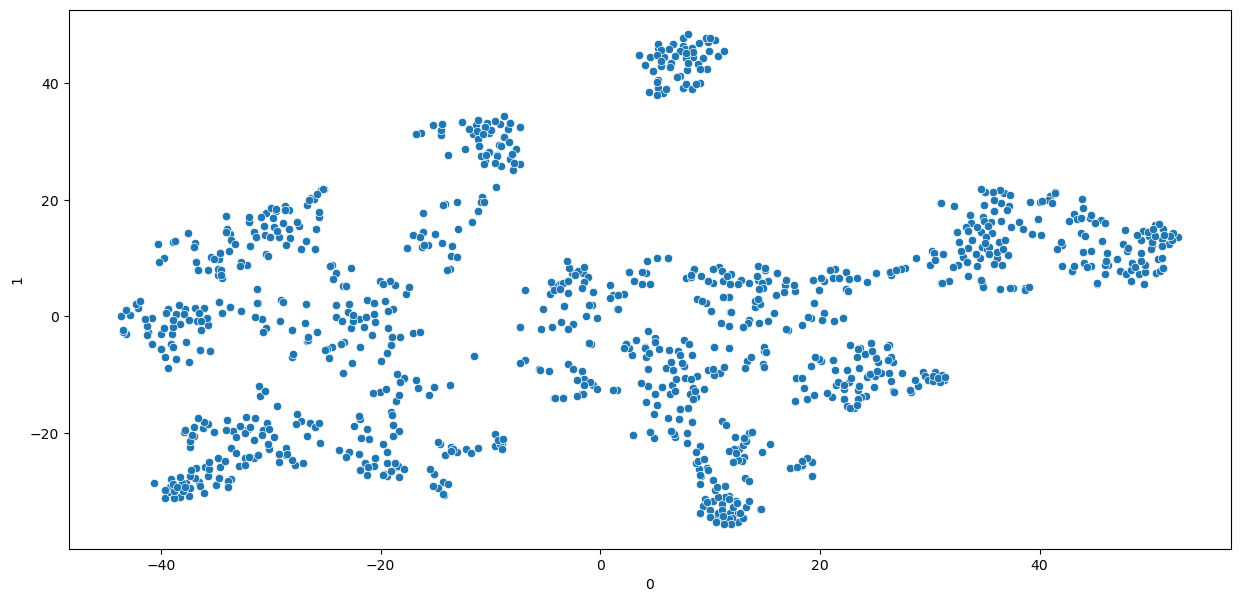

In [257]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# U, S, V = np.linalg.svd(embeddings)
# print(S)

pca = PCA(n_components=8)
pca_embs = pca.fit_transform(embeddings)

pca_cat_emb = {k: v for k,v in zip(minorities, pca_embs)}

tsne = TSNE(n_components=2)
low_dim_data = tsne.fit_transform(pca_embs)

# pca_cat_emb = {k: v for k,v in zip(categories, low_dim_data)}
pca_tsne_df =  pd.DataFrame(low_dim_data)
pca_tsne_df["labels"] = minorities

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.scatterplot(data=pca_tsne_df.loc[3:5], x=0, y=1, color="red", ax=ax)
sns.scatterplot(data=pca_tsne_df, x=0, y=1, ax=ax)
plt.show()

In [254]:
mask = tsne_df[0]>30
tsne_df[mask]

,0,1,labels
9,45.760979,10.868467,assault victims
17,33.159660,11.844923,OD victims
26,34.919216,21.280949,Holocaust victims
27,47.970161,5.965205,rape victims
32,49.191006,5.653676,sex trafficking victims
...,...,...,...
1144,33.561005,13.202026,Fire victims
1147,50.945354,13.994791,"harassment victims, rape victims"
1152,34.970299,15.520514,Boston Marathon victims
1153,36.328423,11.592240,AIDS victims


In [241]:
sim_minorities = {cat: set() for cat in minorities}

for cat1, emb1 in pca_cat_emb.items():
    sim_cat = []
    for cat2, emb2 in pca_cat_emb.items():
        if cat1 != cat2:
            cos_sim = np.dot(emb1, emb2)/(np.linalg.norm(emb1)*np.linalg.norm(emb2))
            if cos_sim > 0.91:
                sim_cat.append(cat2)
    sim_minorities[cat1].update(sim_cat)

In [226]:
sim_minorities.keys()

dict_keys(['liberals', 'middle eastern folks', 'muslim folks', 'muslim folks, arabic folks', 'immigrants', 'women', 'trans women, trans men', 'folks with physical illness/disorder', 'latino/latina folks', 'assault victims', 'black folks', 'Men', 'prisoners', 'white folks', 'mentally disabled folks', 'physically disabled folks', 'folks with mental illness/disorder', 'OD victims', 'lesbian women, gay men, trans women, trans men, bisexual women, bisexual men', 'ugly folks', 'Gypsies', 'gypsies', 'gay men', 'politicians', 'conservatives', 'old folks', 'Holocaust victims', 'rape victims', 'jewish folks', 'conservatives, alt right', 'americans', 'furries', 'sex trafficking victims', 'refugees', 'trans men', 'syrian', 'syrians', 'married folks', 'jamaican folks', 'illegal immigrants', 'asian folks', 'Africans', 'men', 'Islam', 'White folks', 'Thai', 'mass shooting victims', 'overweight/fat folks', 'cancer victims', 'everyone', 'single mothers', 'vegans', 'well off folks', 'White people', 'mur

In [243]:
sim_minorities["African folks"]

{'Mexican people',
 'aboriginal folks',
 'african folks',
 'african people',
 'brown folks',
 'haitians',
 'indigenous folks',
 'jamaican folks',
 'mexican people'}